In [61]:
import jax
import jax.numpy as jnp
import e3nn_jax as e3nn
import plotly.graph_objects as go
import pandas as pd
import optax
import chex
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import functools
sys.path.append('../..')

In [62]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
%autoreload 2

from symphony import loss
from symphony import models
import helpers

In [64]:
# Create a random signal on the sphere, by sampling random points on the sphere.
N_points = 5
lmax = 5
rng = jax.random.PRNGKey(0)
random_points = jax.random.normal(rng, (N_points, 3))
random_points = random_points / jnp.linalg.norm(random_points, axis=-1, keepdims=True)
random_signal = 20 * e3nn.s2_dirac(random_points, lmax=lmax, p_val=1, p_arg=-1)

In [65]:
random_dist = helpers.average_target_distributions(random_signal, 159, 80)
random_dist_copy = e3nn.SphericalSignal(grid_values=random_dist.grid_values[0], quadrature=random_dist.quadrature)
fig = go.Figure([go.Surface(random_dist_copy.plotly_surface(scale_radius_by_amplitude=False, radius=0.8, normalize_radius_by_max_amplitude=True)),
                 go.Scatter3d(x=random_points[:, 0], y=random_points[:, 1], z=random_points[:, 2], mode='markers')])

# Do not show the axis
fig.update_layout(scene = dict(
                    xaxis = dict(showticklabels=False, visible=False),
                    yaxis = dict(showticklabels=False, visible=False),
                    zaxis = dict(showticklabels=False, visible=False)))
fig.show()

In [66]:
# Try to learn random signal via gradient descent on the KL divergence.
def optimize_coeffs(true_signal, lmax, position_channels, res_alpha, res_beta, use_simm_et_al, regularize_coeffs, num_training_steps):

    # Compute the target distribution
    true_dist = helpers.average_target_distributions(true_signal, res_alpha=res_alpha, res_beta=res_beta)

    rng = jax.random.PRNGKey(0)
    irreps = e3nn.s2_irreps(lmax, p_val=1, p_arg=-1)
    coeffs = e3nn.normal(irreps, rng, (position_channels, 1))

    tx = optax.adam(1e-3)
    opt_state = tx.init(coeffs)

    def loss_fn(coeffs):
        log_predicted_dist = models.log_coeffs_to_logits(coeffs, res_beta=res_beta, res_alpha=res_alpha, num_radii=1)
        if use_simm_et_al:
            log_predicted_dist.grid_values = log_predicted_dist.grid_values ** 2
            if regularize_coeffs:
                log_predicted_dist.grid_values = log_predicted_dist.grid_values / e3nn.norm(coeffs, per_irrep=True, squared=True).array.sum()

        return loss.kl_divergence_on_spheres(true_dist, log_predicted_dist)

    @jax.jit
    def train_step(coeffs, opt_state):
        loss_value, grads = jax.value_and_grad(loss_fn)(coeffs)
        grad_norms = jnp.linalg.norm(grads.array)
        updates, opt_state = tx.update(grads, opt_state, coeffs)
        coeffs = optax.apply_updates(coeffs, updates)
        return coeffs, opt_state, loss_value, grad_norms


    training_dict = {}
    for step in range(num_training_steps):
        coeffs, opt_state, loss_value, grad_norms = train_step(coeffs, opt_state)
        if step % 5000 == 0 or step == num_training_steps - 1:
            print(f"Step {step}, Loss: {loss_value}")
    
        if step % 10 == 0:
            # step_rng = jax.random.fold_in(rng, step)
            # dist = helpers.coeffs_to_distribution(coeffs, res_alpha, res_beta)
            # mean_dist, std_dist = helpers.rmse_of_samples(dist, random_points, step_rng, num_samples=1000)
            training_dict[step] = {
                "coeffs": coeffs.array,
                "loss_value": float(loss_value.item()),
                "grad_norms": float(grad_norms.item()),
                # "mean_dist": float(mean_dist),
                # "std_dist": float(std_dist),
            }

    return training_dict


In [67]:
# We vary the number of position channels and lmax.
# See how well we can learn the signal.
results_df = pd.DataFrame(columns=["res_alpha", "res_beta", "lmax", "position_channels", "loss", "loss_diff", "coeffs", "grad_norms", "use_simm_et_al", "regularize_coeffs"])
for res_alpha in [179]:
    for res_beta in [90]:
        for lmax in range(1, 6):
            for position_channels in range(1, 10):
                for use_simm_et_al in [True, False]:
                    for regularize_coeffs in [True, False]:
                        if regularize_coeffs and not use_simm_et_al:
                            continue

                        training_dict = optimize_coeffs(random_signal, lmax, position_channels, res_alpha, res_beta, use_simm_et_al, regularize_coeffs, num_training_steps=10000) 
                
                        first_step = list(training_dict.keys())[0]
                        last_step = list(training_dict.keys())[-1]
                        second_last_step = list(training_dict.keys())[-2]
                        loss_diff = (training_dict[last_step]["loss_value"] - training_dict[second_last_step]["loss_value"]) / (second_last_step - last_step)
                        assert first_step == 0
                        
                        results_df = results_df.append({
                            "res_alpha": res_alpha,
                            "res_beta": res_beta,
                            "lmax": lmax,
                            "position_channels": position_channels,
                            "loss": training_dict[last_step]["loss_value"],
                            "loss_diff": loss_diff,
                            "grad_norms": training_dict[last_step]["grad_norms"],
                            "coeffs": training_dict[last_step]["coeffs"],
                            "use_simm_et_al": use_simm_et_al,
                            "regularize_coeffs": regularize_coeffs,
                        }, ignore_index=True)


Step 0, Loss: 4.881007194519043
Step 5000, Loss: 4.133732795715332
Step 9999, Loss: 4.142509937286377


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Step 0, Loss: 9.963494300842285
Step 5000, Loss: 4.132734298706055
Step 9999, Loss: 4.132734775543213


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 4.654016017913818
Step 5000, Loss: 4.163882255554199
Step 9999, Loss: 4.163882732391357


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 4.590633392333984
Step 5000, Loss: 3.99727463722229
Step 9999, Loss: 4.007110595703125


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 22.912498474121094
Step 5000, Loss: 3.978482961654663
Step 9999, Loss: 3.4019460678100586


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 5.853625297546387
Step 5000, Loss: 3.3757781982421875
Step 9999, Loss: 3.3162193298339844


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 4.409951686859131
Step 5000, Loss: 4.025297164916992
Step 9999, Loss: 4.026288032531738


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 9.43067455291748
Step 5000, Loss: 3.152914047241211
Step 9999, Loss: 2.645378351211548


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 4.397069931030273
Step 5000, Loss: 3.336813449859619
Step 9999, Loss: 3.3160998821258545


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 4.2689056396484375
Step 5000, Loss: 4.0479350090026855
Step 9999, Loss: 4.049277305603027


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 12.355921745300293
Step 5000, Loss: 2.8069748878479004
Step 9999, Loss: 2.0101513862609863


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 5.031904220581055
Step 5000, Loss: 3.0166661739349365
Step 9999, Loss: 2.8023784160614014


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 4.209784030914307
Step 5000, Loss: 4.0704240798950195
Step 9999, Loss: 4.070489883422852


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 8.386063575744629
Step 5000, Loss: 1.9778746366500854
Step 9999, Loss: 0.7894096970558167


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 5.197959899902344
Step 5000, Loss: 2.9670772552490234
Step 9999, Loss: 2.799539566040039


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 4.229301452636719
Step 5000, Loss: 4.0908284187316895
Step 9999, Loss: 4.090827941894531


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 6.194578170776367
Step 5000, Loss: 0.8192845582962036
Step 9999, Loss: 0.27357017993927


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 4.971966743469238
Step 5000, Loss: 2.9530935287475586
Step 9999, Loss: 2.8034093379974365


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 4.346434593200684
Step 5000, Loss: 4.107940673828125
Step 9999, Loss: 4.107936859130859


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 11.128584861755371
Step 5000, Loss: 1.4584589004516602
Step 9999, Loss: 0.13325941562652588


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 4.191214561462402
Step 5000, Loss: 2.891781806945801
Step 9999, Loss: 2.7583634853363037


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 4.280622959136963
Step 5000, Loss: 4.121551513671875
Step 9999, Loss: 4.121585845947266


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 4.865123748779297
Step 5000, Loss: 0.6286449432373047
Step 9999, Loss: 0.27278149127960205


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 4.431606292724609
Step 5000, Loss: 2.9342212677001953
Step 9999, Loss: 2.787628173828125


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 4.341208457946777
Step 5000, Loss: 4.1313581466674805
Step 9999, Loss: 4.131692886352539


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 11.397016525268555
Step 5000, Loss: 0.9888590574264526
Step 9999, Loss: 0.1294635534286499


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 3.7889881134033203
Step 5000, Loss: 2.8916196823120117
Step 9999, Loss: 2.7681448459625244


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 9.159557342529297
Step 5000, Loss: 3.1803691387176514
Step 9999, Loss: 3.182018756866455


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 19.98190689086914
Step 5000, Loss: 3.1800453662872314
Step 9999, Loss: 3.1800320148468018


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 6.000319480895996
Step 5000, Loss: 3.145002841949463
Step 9999, Loss: 3.1386728286743164


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 5.025230407714844
Step 5000, Loss: 3.1805434226989746
Step 9999, Loss: 3.2106125354766846


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 51.22260284423828
Step 5000, Loss: 1.7058396339416504
Step 9999, Loss: 1.542141318321228


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 7.021060943603516
Step 5000, Loss: 2.7872395515441895
Step 9999, Loss: 2.658961057662964


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 4.283608436584473
Step 5000, Loss: 5.8436079025268555
Step 9999, Loss: 3.2930545806884766


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 56.76481246948242
Step 5000, Loss: 0.9175836443901062
Step 9999, Loss: 0.2558847665786743


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 8.216011047363281
Step 5000, Loss: 2.3563103675842285
Step 9999, Loss: 1.8227875232696533


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 4.603299617767334
Step 5000, Loss: 3.346853733062744
Step 9999, Loss: 3.962297201156616


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 82.9698486328125
Step 5000, Loss: 0.5925278663635254
Step 9999, Loss: 0.16839873790740967


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 5.814743518829346
Step 5000, Loss: 1.8514735698699951
Step 9999, Loss: 1.283935308456421


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 4.069360733032227
Step 5000, Loss: 3.4562087059020996
Step 9999, Loss: 3.5590672492980957


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 41.301448822021484
Step 5000, Loss: 0.15833830833435059
Step 9999, Loss: 0.011558055877685547


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 7.450324535369873
Step 5000, Loss: 2.141005516052246
Step 9999, Loss: 1.6986981630325317


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 4.3752336502075195
Step 5000, Loss: 4.089933395385742
Step 9999, Loss: 3.6965768337249756


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 32.81571960449219
Step 5000, Loss: 0.07972574234008789
Step 9999, Loss: 0.02425074577331543


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 5.021166801452637
Step 5000, Loss: 1.6951100826263428
Step 9999, Loss: 1.2005841732025146


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 4.351255893707275
Step 5000, Loss: 3.674624443054199
Step 9999, Loss: 4.306604385375977


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 35.966697692871094
Step 5000, Loss: 0.04594135284423828
Step 9999, Loss: 0.024193406105041504


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 4.836165428161621
Step 5000, Loss: 1.5711137056350708
Step 9999, Loss: 0.9974499940872192


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 4.313126564025879
Step 5000, Loss: 4.3520612716674805
Step 9999, Loss: 4.392839431762695


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 23.41180419921875
Step 5000, Loss: 0.051659226417541504
Step 9999, Loss: 0.009810328483581543


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 4.946627616882324
Step 5000, Loss: 1.748247742652893
Step 9999, Loss: 1.2585383653640747


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 4.314605712890625
Step 5000, Loss: 4.195797443389893
Step 9999, Loss: 3.785309076309204


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 57.411354064941406
Step 5000, Loss: 0.13519299030303955
Step 9999, Loss: 0.025333404541015625


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 5.349001407623291
Step 5000, Loss: 1.3744757175445557
Step 9999, Loss: 0.7834915518760681


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 15.86506462097168
Step 5000, Loss: 2.2897965908050537
Step 9999, Loss: 2.251418352127075


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 211.6211395263672
Step 5000, Loss: 1.7040010690689087
Step 9999, Loss: 1.3501802682876587


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 7.337957859039307
Step 5000, Loss: 2.358090400695801
Step 9999, Loss: 1.9967741966247559


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 6.000418186187744
Step 5000, Loss: 2.748711585998535
Step 9999, Loss: 2.7818727493286133


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 139.96353149414062
Step 5000, Loss: 0.7421411275863647
Step 9999, Loss: 0.1598062515258789


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 6.8339762687683105
Step 5000, Loss: 2.240903615951538
Step 9999, Loss: 1.9550914764404297


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 4.994668960571289
Step 5000, Loss: 4.206908226013184
Step 9999, Loss: 2.916762590408325


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 125.39334106445312
Step 5000, Loss: 0.11768805980682373
Step 9999, Loss: 0.011871695518493652


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 6.426033973693848
Step 5000, Loss: 1.157287359237671
Step 9999, Loss: 0.649645209312439


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 4.127293586730957
Step 5000, Loss: 4.022789001464844
Step 9999, Loss: 3.3205950260162354


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 46.10759735107422
Step 5000, Loss: 0.04358363151550293
Step 9999, Loss: 0.012583494186401367


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 7.207752227783203
Step 5000, Loss: 1.4071381092071533
Step 9999, Loss: 0.8688289523124695


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 4.359837055206299
Step 5000, Loss: 3.9284114837646484
Step 9999, Loss: 3.4101293087005615


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 66.77981567382812
Step 5000, Loss: 0.044989943504333496
Step 9999, Loss: 0.00825512409210205


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 5.779730796813965
Step 5000, Loss: 1.0591950416564941
Step 9999, Loss: 0.5445208549499512


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 4.332571029663086
Step 5000, Loss: 3.7214598655700684
Step 9999, Loss: 3.3619542121887207


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 52.29194641113281
Step 5000, Loss: 0.025174856185913086
Step 9999, Loss: 0.0029734373092651367


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 5.298913955688477
Step 5000, Loss: 0.6864331960678101
Step 9999, Loss: 0.2201390266418457


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 4.377501487731934
Step 5000, Loss: 3.896378517150879
Step 9999, Loss: 3.866208076477051


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 87.85606384277344
Step 5000, Loss: 0.02131056785583496
Step 9999, Loss: 0.004766345024108887


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 5.849537372589111
Step 5000, Loss: 0.613559365272522
Step 9999, Loss: 0.16319823265075684


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 4.278748512268066
Step 5000, Loss: 3.607394218444824
Step 9999, Loss: 3.8668909072875977


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 83.02009582519531
Step 5000, Loss: 0.017815589904785156
Step 9999, Loss: 0.002933979034423828


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 7.720870018005371
Step 5000, Loss: 0.6994271278381348
Step 9999, Loss: 0.20193111896514893


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 4.350844383239746
Step 5000, Loss: 3.650508165359497
Step 9999, Loss: 3.6404495239257812


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 76.79019165039062
Step 5000, Loss: 0.027219533920288086
Step 9999, Loss: 0.002684354782104492


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 6.5932936668396
Step 5000, Loss: 0.6189072132110596
Step 9999, Loss: 0.16855812072753906


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 8.78889274597168
Step 5000, Loss: 1.9918452501296997
Step 9999, Loss: 3.707545757293701


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 254.04771423339844
Step 5000, Loss: 0.28188037872314453
Step 9999, Loss: 0.10711777210235596


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 11.932249069213867
Step 5000, Loss: 2.0221641063690186
Step 9999, Loss: 1.3663437366485596


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 6.29752779006958
Step 5000, Loss: 2.4457175731658936
Step 9999, Loss: 3.6889078617095947


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 248.33724975585938
Step 5000, Loss: 0.1071094274520874
Step 9999, Loss: 0.035385966300964355


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 7.903433799743652
Step 5000, Loss: 0.9792718291282654
Step 9999, Loss: 0.4423229694366455


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 4.236669063568115
Step 5000, Loss: 4.042535781860352
Step 9999, Loss: 2.8432319164276123


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 250.322265625
Step 5000, Loss: 0.10350692272186279
Step 9999, Loss: 0.017220497131347656


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 13.410795211791992
Step 5000, Loss: 1.0931966304779053
Step 9999, Loss: 0.5466533899307251


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 5.053506851196289
Step 5000, Loss: 3.7842249870300293
Step 9999, Loss: 3.063149929046631


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 260.5299072265625
Step 5000, Loss: 0.09876656532287598
Step 9999, Loss: 0.007778286933898926


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 8.9074068069458
Step 5000, Loss: 0.6674225330352783
Step 9999, Loss: 0.23576223850250244


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 4.505221843719482
Step 5000, Loss: 3.0813851356506348
Step 9999, Loss: 3.3837172985076904


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 279.88134765625
Step 5000, Loss: 0.09087026119232178
Step 9999, Loss: 0.009240269660949707


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 6.82832145690918
Step 5000, Loss: 0.2693800926208496
Step 9999, Loss: 0.03513753414154053


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 4.4033098220825195
Step 5000, Loss: 3.5224413871765137
Step 9999, Loss: 3.8518588542938232


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 123.23231506347656
Step 5000, Loss: 0.028679847717285156
Step 9999, Loss: 0.0020220279693603516


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 6.005645275115967
Step 5000, Loss: 0.18886733055114746
Step 9999, Loss: 0.0052928924560546875


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 4.336033821105957
Step 5000, Loss: 3.783292293548584
Step 9999, Loss: 3.589810848236084


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 97.32754516601562
Step 5000, Loss: 0.02427542209625244
Step 9999, Loss: 0.0029969215393066406


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 6.0778961181640625
Step 5000, Loss: 0.28334617614746094
Step 9999, Loss: 0.01937270164489746


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 4.445310115814209
Step 5000, Loss: 3.867919683456421
Step 9999, Loss: 3.7051830291748047


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 215.03675842285156
Step 5000, Loss: 0.06647849082946777
Step 9999, Loss: 0.010074973106384277


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 8.333084106445312
Step 5000, Loss: 0.2924154996871948
Step 9999, Loss: 0.039013028144836426


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 4.286965370178223
Step 5000, Loss: 3.5217084884643555
Step 9999, Loss: 4.610329627990723


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 147.35023498535156
Step 5000, Loss: 0.026708006858825684
Step 9999, Loss: 0.003957152366638184


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 8.172531127929688
Step 5000, Loss: 0.2924751043319702
Step 9999, Loss: 0.03744792938232422


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 19.79582977294922
Step 5000, Loss: 0.9936187267303467
Step 9999, Loss: 0.44578826427459717


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 842.2883911132812
Step 5000, Loss: 0.9025263786315918
Step 9999, Loss: 0.07780313491821289


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 10.611387252807617
Step 5000, Loss: 0.49772679805755615
Step 9999, Loss: 0.10108757019042969


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 6.348333358764648
Step 5000, Loss: 2.7686991691589355
Step 9999, Loss: 2.2676568031311035


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 377.619873046875
Step 5000, Loss: 0.15439152717590332
Step 9999, Loss: 0.012720108032226562


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 8.355302810668945
Step 5000, Loss: 0.26644980907440186
Step 9999, Loss: 0.04843032360076904


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 4.864602088928223
Step 5000, Loss: 2.2212367057800293
Step 9999, Loss: 2.63230037689209


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 407.0277099609375
Step 5000, Loss: 0.23906254768371582
Step 9999, Loss: 0.013564467430114746


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 11.945157051086426
Step 5000, Loss: 0.18996918201446533
Step 9999, Loss: 0.009589314460754395


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 4.520960807800293
Step 5000, Loss: 3.6258621215820312
Step 9999, Loss: 1.9020363092422485


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 517.53515625
Step 5000, Loss: 0.20420217514038086
Step 9999, Loss: 0.03243553638458252


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 10.724231719970703
Step 5000, Loss: 0.08627629280090332
Step 9999, Loss: 0.0016107559204101562


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 4.45249605178833
Step 5000, Loss: 3.945819616317749
Step 9999, Loss: 4.431556224822998


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 211.35035705566406
Step 5000, Loss: 0.030015230178833008
Step 9999, Loss: 0.005212187767028809


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 6.890725135803223
Step 5000, Loss: 0.056215524673461914
Step 9999, Loss: 0.0007128715515136719


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 4.452784538269043
Step 5000, Loss: 3.2980237007141113
Step 9999, Loss: 3.083209753036499


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 299.3765869140625
Step 5000, Loss: 0.027855515480041504
Step 9999, Loss: 0.00774383544921875


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 6.417248249053955
Step 5000, Loss: 0.048596858978271484
Step 9999, Loss: 0.00041162967681884766


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 4.49772834777832
Step 5000, Loss: 2.829587936401367
Step 9999, Loss: 3.8391518592834473


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 353.4629821777344
Step 5000, Loss: 0.043938517570495605
Step 9999, Loss: 0.00646054744720459


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 5.864012241363525
Step 5000, Loss: 0.03129839897155762
Step 9999, Loss: 0.00018095970153808594


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 4.116670608520508
Step 5000, Loss: 2.909337043762207
Step 9999, Loss: 3.0506014823913574


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 167.91012573242188
Step 5000, Loss: 0.03216707706451416
Step 9999, Loss: 0.005121827125549316


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 12.367291450500488
Step 5000, Loss: 0.05388510227203369
Step 9999, Loss: 0.0008072853088378906


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 4.191828727722168
Step 5000, Loss: 3.398998737335205
Step 9999, Loss: 3.049736499786377


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 199.4456329345703
Step 5000, Loss: 0.020144224166870117
Step 9999, Loss: 0.0031359195709228516


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



Step 0, Loss: 11.667901992797852
Step 5000, Loss: 0.0561673641204834
Step 9999, Loss: 0.0005476474761962891


/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/rf/gl_bs24d2sg1ptcd__f19_pw0000gn/T/ipykernel_82329/3926213448.py:21: FutureWarning:

In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.



In [68]:
results_df

,res_alpha,res_beta,lmax,position_channels,loss,loss_diff,coeffs,grad_norms,use_simm_et_al,regularize_coeffs
0,179,90,1,1,4.142500,-1.192093e-06,"[[[8.784339, -2.091224, 1.4061668, 3.5710196]]]",5.957104e-02,True,True
1,179,90,1,1,4.132736,-9.536743e-08,"[[[9.1413, -0.20335937, 0.13667887, 0.35087213]]]",2.619110e-01,True,False
2,179,90,1,1,4.163882,-0.000000e+00,"[[[8.396719, 0.25691137, 0.18612164, -0.383007...",1.631855e-07,False,False
3,179,90,1,2,4.005351,-4.289627e-04,"[[[-0.3949728, -0.51498353, 0.31394354, -0.172...",2.289707e-02,True,True
4,179,90,1,2,3.402462,5.726814e-05,"[[[-1.5063903, 1.6648012, -0.74517024, 1.82970...",5.118626e-02,True,False
...,...,...,...,...,...,...,...,...,...,...
130,179,90,5,8,0.005126,1.518726e-05,"[[[-0.2964077, -0.2702964, 1.2611184, 1.266939...",3.188727e-01,True,False
131,179,90,5,8,0.000813,5.602837e-07,"[[[-1.6522447, 0.6395734, 0.7104303, 0.2521313...",1.324314e-03,False,False
132,179,90,5,9,2.901429,5.710506e-03,"[[[-0.00035815488, -4.7082412e-05, 1.34846005e...",1.998912e+02,True,True
133,179,90,5,9,0.003129,1.370907e-06,"[[[-0.3778028, 0.030209694, -0.86740875, -0.07...",3.725709e-01,True,False


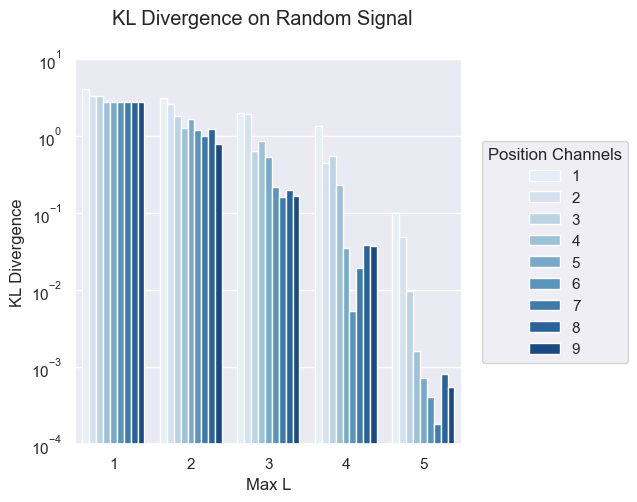

In [69]:
fig, ax = plt.subplots(ncols=1, figsize=(5, 5), sharey=True, sharex=True)
sns.set_theme(style="darkgrid")

# Make 1 plot, one for results where:
# * use_simm_et_al = True, regularize_coeffs = True
# * use_simm_et_al = True, regularize_coeffs = False
sns.barplot(data=results_df[results_df["use_simm_et_al"] == False], x="lmax", y="loss", hue="position_channels", palette="Blues", ax=ax)


fig.suptitle("KL Divergence on Random Signal")
ax.set_yscale("log")
ax.set_ylim([1e-4, 1e1])

# Remove legends
ax.get_legend().remove()

# Set x-axis label as "Max L"
ax.set_xlabel("Max L")
# ax.set_title("Symphony Parametrization")

# Set y-axis label as "KL Divergence"
ax.set_ylabel("KL Divergence")
# Place legend outside the figure
plt.legend(bbox_to_anchor=(1.05, 0.5), loc="center left", borderaxespad=0., title="Position Channels")
plt.savefig("pdfs/kl_divergence_random_signal.pdf", dpi=500, bbox_inches='tight')
plt.show()

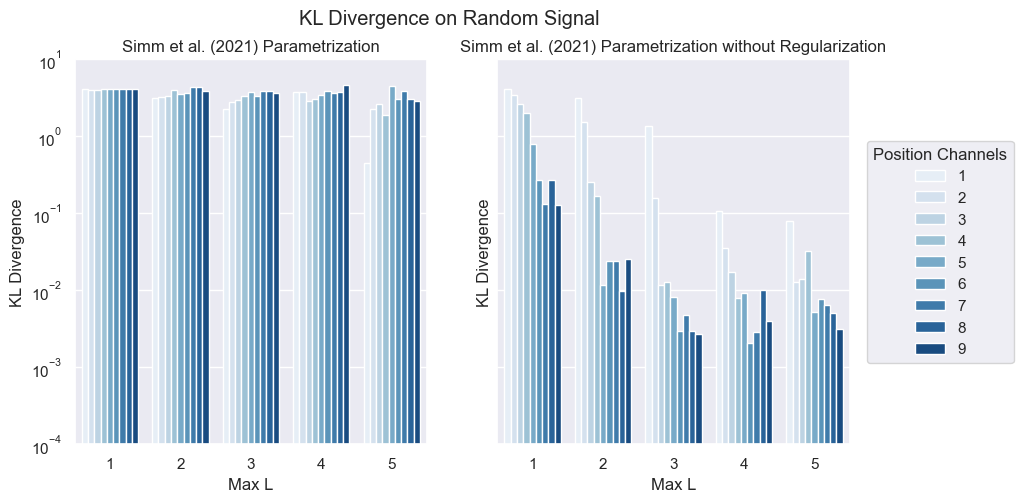

In [72]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5), sharey=True, sharex=True)
sns.set_theme(style="darkgrid")


# Make 2 plots, one for results where:
# * use_simm_et_al = True, regularize_coeffs = True
# * use_simm_et_al = True, regularize_coeffs = False
sns.barplot(data=results_df[(results_df["use_simm_et_al"] == True) & (results_df["regularize_coeffs"] == True)], x="lmax", y="loss", hue="position_channels", palette="Blues", ax=axs[0])
sns.barplot(data=results_df[(results_df["use_simm_et_al"] == True) & (results_df["regularize_coeffs"] == False)], x="lmax", y="loss", hue="position_channels", palette="Blues", ax=axs[1])


fig.suptitle("KL Divergence on Random Signal")
# Remove legends
axs[0].get_legend().remove()
axs[0].set_yscale("log")
axs[0].set_ylim([1e-4, 1e1])

# Set x-axis label as "Max L"
axs[0].set_xlabel("Max L")
axs[1].set_xlabel("Max L")
axs[0].set_title("Simm et al. (2021) Parametrization")
axs[1].set_title("Simm et al. (2021) Parametrization without Regularization")

# Set y-axis label as "KL Divergence"
axs[0].set_ylabel("KL Divergence")
axs[1].set_ylabel("KL Divergence")

# Place legend outside the figure
plt.legend(bbox_to_anchor=(1.05, 0.5), loc="center left", borderaxespad=0., title="Position Channels")
plt.savefig("pdfs/kl_divergence_random_signal_simm.pdf", dpi=500, bbox_inches='tight')
plt.show()

In [71]:
lmax = 5
position_channels = 1
use_simm_et_al = True
regularize_coeffs = True

results_df_subset = results_df[(results_df["lmax"] == lmax) & (results_df["use_simm_et_al"] == use_simm_et_al) & (results_df["regularize_coeffs"] == regularize_coeffs) & (results_df["position_channels"] == position_channels)]
print(results_df_subset)

coeffs = results_df_subset["coeffs"].values.item()
coeffs = e3nn.IrrepsArray(e3nn.s2_irreps(lmax, p_val=1, p_arg=-1), coeffs)

predicted_dist = models.log_coeffs_to_logits(coeffs, res_beta=90, res_alpha=179, num_radii=1)
if use_simm_et_al:
    predicted_dist.grid_values = predicted_dist.grid_values ** 2
    if regularize_coeffs:
        predicted_dist.grid_values = predicted_dist.grid_values / e3nn.norm(coeffs, per_irrep=True, squared=True).array.sum()

predicted_dist = models.position_logits_to_position_distribution(predicted_dist)
samples_rng, rng = jax.random.split(rng)
samples = helpers.sample_from_dist(predicted_dist, samples_rng, num_samples=10)

predicted_dist.grid_values = predicted_dist.grid_values[0]
fig = go.Figure([go.Surface(predicted_dist.plotly_surface(scale_radius_by_amplitude=False, radius=0.8, normalize_radius_by_max_amplitude=True)),
                 go.Scatter3d(x=samples[:, 0], y=samples[:, 1], z=samples[:, 2], mode='markers'),
                 go.Scatter3d(x=random_points[:, 0], y=random_points[:, 1], z=random_points[:, 2], mode='markers')])
fig.update_layout(scene = dict(
                    xaxis = dict(showticklabels=False, visible=False),
                    yaxis = dict(showticklabels=False, visible=False),
                    zaxis = dict(showticklabels=False, visible=False)))
fig.show()

    res_alpha res_beta lmax position_channels     loss  loss_diff  \
108       179       90    5                 1  0.44554  -0.000028   

                                                coeffs  grad_norms  \
108  [[[-0.48312294, -0.11823476, -0.43084225, 0.50...    0.106811   

    use_simm_et_al regularize_coeffs  
108           True              True  
